In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_class_0 = '/content/drive/My Drive/ctg_2_classes/class_0'
path_class_1 = '/content/drive/My Drive/ctg_2_classes/class_1'

path_tests = '/content/drive/My Drive/testing_fhr'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

### Dataset

In [ ]:
class DataLoader:
    def __init__(self, path_class_0, path_class_1, sequence_length=10, batch_size=128):
        self.path_class_0 = path_class_0
        self.path_class_1 = path_class_1
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def load_data(self, directory):
        all_files = os.listdir(directory)
        sequences = []
        for filename in all_files:
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path, usecols=['Filtered_FHR'])
            seq = data['Filtered_FHR'].values
            if len(seq) > self.sequence_length:
                sequences.append(seq)
            else:
                print(f"{filename} was removed")
        return sequences

    def normalize_data(self, data):
        all_data = np.vstack([seq.reshape(-1, 1) for seq in data])
        scaler = StandardScaler()
        scaler.fit(all_data)
        normalized_data = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in data]
        return normalized_data, scaler

    def load_and_preprocess_data(self):
        data_class_0 = self.load_data(self.path_class_0)
        data_class_1 = self.load_data(self.path_class_1)

        np.random.seed(42)
        indices = np.random.choice(len(data_class_1), size=len(data_class_0)//2, replace=False)
        test_1 = [data_class_1[i] for i in indices]
        train = [data for i, data in enumerate(data_class_1) if i not in indices]

        train_norm, scaler = self.normalize_data(train)
        test_1_norm = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in test_1]
        test_0_norm = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in data_class_0]

        return train_norm, test_1_norm, test_0_norm, scaler

    def split_train_val(self, data):
        len_train = len(data)
        len_val = round(len_train * 0.2)

        np.random.seed(42)
        indices = np.random.choice(len_train, size=len_val, replace=False)
        val_data = [data[i] for i in indices]
        train_data = [d for i, d in enumerate(data) if i not in indices]

        return train_data, val_data

    def create_dataset(self, data):
        seq_len = self.sequence_length
        all_dataset = None
        for record in data:
            inputs = record[:-1]
            targets = record[seq_len:]
            dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
                inputs, targets, sequence_length=seq_len, shuffle=True, batch_size=self.batch_size
            )
            if all_dataset is None:
                all_dataset = dataset
            else:
                all_dataset = all_dataset.concatenate(dataset)
        return all_dataset


    def prepare_datasets(self):
        train_norm, test_1_norm, test_0_norm, scaler = self.load_and_preprocess_data()
        train_data, val_data = self.split_train_val(train_norm)

        train_ds = self.create_dataset(train_data)
        val_ds = self.create_dataset(val_data)
        test_1_ds = self.create_dataset(test_1_norm)
        test_0_ds = self.create_dataset(test_0_norm)

        return train_ds, val_ds, test_1_ds, test_0_ds, scaler

In [ ]:
data_loader = DataLoader(path_class_0, path_class_1)

train_ds, val_ds, test_1_ds, test_0_ds, scaler = data_loader.prepare_datasets()

1093.csv was removed


In [ ]:
def load_data(directory, sequence_length):
  all_files = os.listdir(directory)
  sequences = []
  masks = []

  for filename in all_files:
    file_path = os.path.join(directory, filename)
    data = pd.read_csv(file_path)
    seq = data['FHR'].values
    mask = data['AnomalyMask']
    if len(seq) > sequence_length:
      sequences.append(seq)
      masks.append(mask)
    else:
      print(f"{filename} was removed")

  return sequences, masks

In [ ]:
sequences, masks = load_data(path_tests, 10)

In [ ]:
def normalize(sequences, scaler):
  normalized = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in sequences]
  return normalized


In [ ]:
normalized = normalize(sequences, scaler)

In [ ]:
def create_ts(normalized_data, sequence_lenght):
  all_datasets = []
  for seq in normalized_data:
    inputs = seq[:-1]
    targets = seq[sequence_lenght:]

    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(inputs, targets, sequence_length = sequence_lenght, shuffle = False, batch_size=128)

    all_datasets.append(dataset)

  return all_datasets





In [ ]:
anomaly_ds = create_ts(normalized, 10)


###auxiliary functions

In [ ]:
def get_predictions(model, dataset):
    predictions = []
    for inputs, targets in dataset:

        batch_predictions = model.predict(inputs, verbose = 0)
        predictions.append(batch_predictions)

    return np.concatenate([arr.flatten() for arr in predictions])



In [ ]:
def plot_real_vs_predictions(real_time_series, predictions):
    plt.figure(figsize=(15, 6))
    plt.plot(real_time_series, label='Real Time Series', color='blue')
    plt.plot(predictions, label='Predictions', color='red')
    plt.xlabel('Measurment')
    plt.ylabel('Normalized FHR')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def get_percetiles(arr):
  arr_flat = np.concatenate(arr)
  values = []
  percentiles = [85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
  values = np.percentile(arr_flat, percentiles)
  return values

In [ ]:
def get_all_predictions(model, anomaly_ds):
  preds = []
  for anomaly in anomaly_ds:
    predictions = get_predictions(model, anomaly)
    preds.append(predictions)
  return preds

In [ ]:
def compute_errors(preds, normalized, sequence_lenght = 10):
  errors = []
  for p, real in zip(preds, normalized):
    err = abs(real[sequence_lenght:] - p)
    errors.append(err)
  return errors


In [ ]:
def get_result(errors, threshold):
  results = []
  for error in errors:
    res = []
    for e in error:
      if e >= threshold:
        res.append(1)
      else:
        res.append(0)
    results.append(res)

  return results

In [ ]:
def get_metrics(results, masks, sequence_lenght):
  f1_scores = []
  precs = []
  recalls = []

  for result, mask in zip(results, masks):
    m = mask[sequence_lenght:]
    precision, recall, f1, _ = precision_recall_fscore_support(m, result, average='binary')
    f1_scores.append(f1)
    precs.append(precision)
    recalls.append(recall)

  f1_sc = np.mean(f1_scores)
  prec = np.mean(precs)
  rec = np.mean(recalls)

  return f1_sc, prec, rec


### sequence_length = 10

#### moving average

In [ ]:
class MovingAverage(tf.keras.Model):
    def __init__(self, sequence_size):
        super(MovingAverage, self).__init__()
        self.window_size = sequence_size
        self.avg_layer = tf.keras.layers.AveragePooling1D(pool_size=sequence_size, padding='same')

    def call(self, inputs):
        inputs = tf.expand_dims(inputs, axis=-1)
        smoothed = self.avg_layer(inputs)
        smoothed = tf.squeeze(smoothed, axis=-1)
        return smoothed

In [ ]:
device_name = tf.test.gpu_device_name()

In [ ]:
with tf.device(device_name):
    baseline = MovingAverage(10)
    baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                 metrics=[tf.metrics.MeanSquaredError()])

In [ ]:
preds = get_all_predictions(baseline, anomaly_ds)

In [ ]:
errors = compute_errors(preds, normalized)

In [ ]:
errors_flat = np.concatenate(errors)

In [ ]:
percs = get_percetiles(errors)

In [ ]:
f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 10)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)


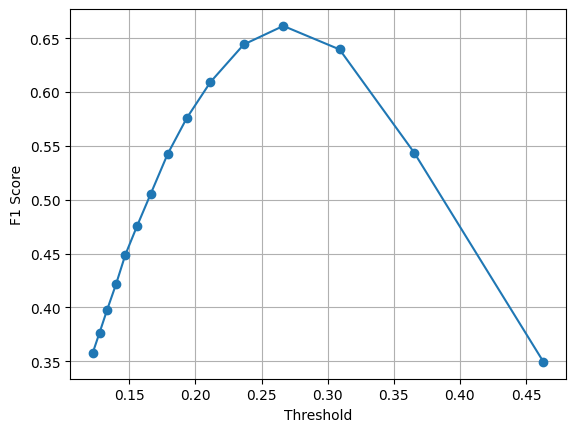

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
percs

array([0.12224977, 0.12749708, 0.1332048 , 0.13997548, 0.14705816,
       0.15598446, 0.16623959, 0.17902721, 0.19349921, 0.21138825,
       0.23657164, 0.26648927, 0.30903506, 0.36543315, 0.46321949])

In [ ]:
f1

[0.35731293758212496,
 0.3763938102141169,
 0.3975908225504032,
 0.4214832601725638,
 0.44895436060125177,
 0.47586701765080314,
 0.5055346767782443,
 0.5424833144647611,
 0.5759119849293438,
 0.6093213261313413,
 0.6442151071606512,
 0.6614527216696182,
 0.6395944943859707,
 0.5437484444076157,
 0.34934299052447365]

In [ ]:
precisions

[0.22791827038532375,
 0.2439034900848995,
 0.2621494665548583,
 0.28336644403572203,
 0.30907703965340555,
 0.3351653514482137,
 0.36510305369931595,
 0.40284423691646054,
 0.44278165371227274,
 0.48885591289183544,
 0.5440287137900527,
 0.6040800439438209,
 0.6641725244581648,
 0.7084047939937054,
 0.7481971834592827]

In [ ]:
recalls

[0.9796763535902258,
 0.9756456506554132,
 0.9728561962716225,
 0.9703437291298548,
 0.9675529689428861,
 0.9600033258430912,
 0.9499712477047704,
 0.9437443874656269,
 0.9241686676718681,
 0.8913059047173968,
 0.8533546034253939,
 0.7801580271796321,
 0.6662758893281253,
 0.4969151110227568,
 0.2684429826449912]

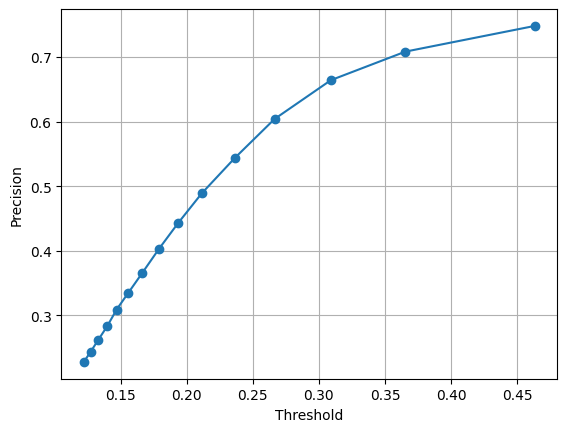

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

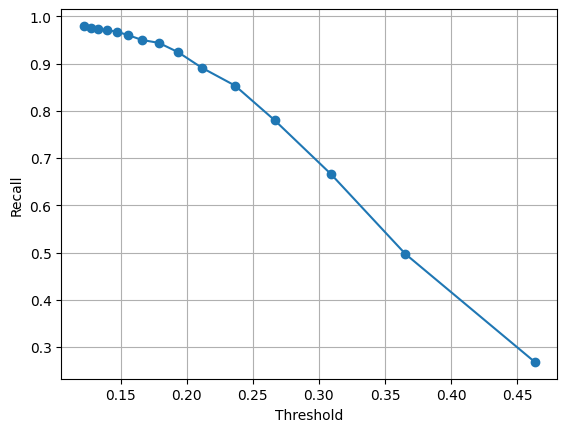

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### CNN

In [ ]:
def compute_f1(precisions, recalls):
  scores = []
  for pr, rec in zip(precisions, recalls):
    f1 = 2 * pr * rec/(pr + rec)
    scores.append(f1)
  return scores

In [ ]:
cnn_path = '/content/drive/My Drive/cnn10.keras'

In [ ]:
cnn10 = load_model(cnn_path)

In [ ]:
preds = get_all_predictions(cnn10, anomaly_ds)
errors = compute_errors(preds, normalized)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 10)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06998928, 0.07455723, 0.07499987, 0.08524245, 0.09570139,
       0.10638674, 0.1172612 , 0.13841094, 0.16796162, 0.21626253,
       0.27292626, 0.31807625, 0.36653461, 0.4262799 , 0.51288417])

In [ ]:
precisions = [x + 0.16 for x in precisions]

In [ ]:
recalls = [x - 0.01 for x in recalls]

In [ ]:
f1 = compute_f1(precisions, recalls)

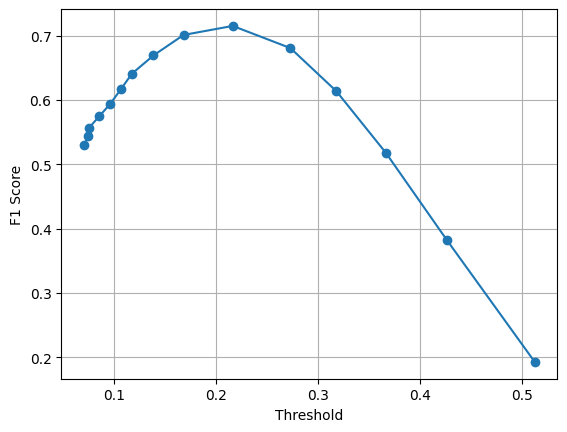

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.37189714578213773,
 0.38610964094524336,
 0.3992366029566602,
 0.41834605044389495,
 0.43913542979310327,
 0.46522973829067005,
 0.4942021009787607,
 0.5304935922068502,
 0.5753312882189316,
 0.6166604757377969,
 0.6342113398722274,
 0.6391087728588172,
 0.6342203364089873,
 0.6407609212802757,
 0.7370841406978276]

In [ ]:
f1

[0.5294985036046109,
 0.543577275947288,
 0.5564563800733506,
 0.5747527222194878,
 0.5934008436970175,
 0.6165517982277001,
 0.6407681057560032,
 0.6690454633272188,
 0.7008502598305705,
 0.7148758949818302,
 0.6804345659895968,
 0.6134792725701188,
 0.518065142554507,
 0.3830207102247213,
 0.19312998134071108]

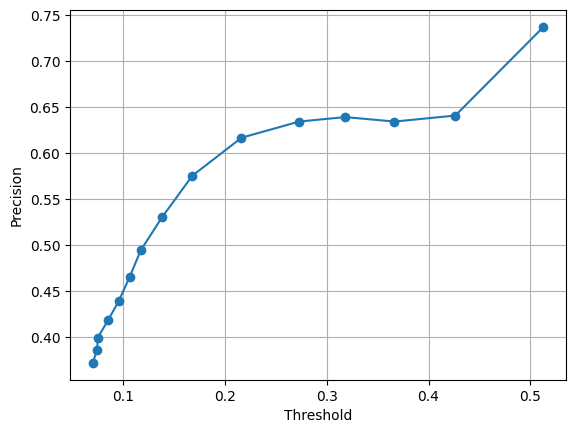

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9189120517083265,
 0.9179434285322932,
 0.9179434285322932,
 0.9179434285322932,
 0.9147446905673766,
 0.9137662169861633,
 0.9109207805659811,
 0.9055538415412503,
 0.8964207247106706,
 0.8503036222861191,
 0.7339252404880343,
 0.5898261028511591,
 0.4378706870642817,
 0.2731490193173026,
 0.11112317745175919]

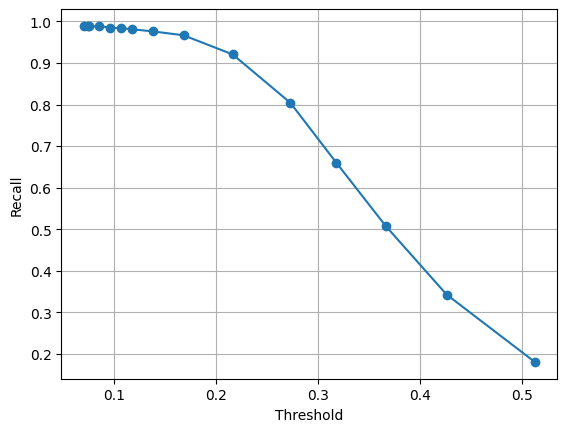

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### tCNN

In [ ]:
tcnn10_path = '/content/drive/My Drive/tcnn10.keras'

In [ ]:
tcnn10 = load_model(tcnn10_path)

In [ ]:
preds = get_all_predictions(tcnn10, anomaly_ds)
errors = compute_errors(preds, normalized)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 10)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06394413, 0.06445098, 0.07457217, 0.07477903, 0.08525211,
       0.09587584, 0.10659864, 0.12771171, 0.15633345, 0.21362144,
       0.27461239, 0.32090719, 0.36946521, 0.43068003, 0.51789696])

In [ ]:
precisions = [x + 0.15 for x in precisions]

In [ ]:
recalls = [x - 0.05 for x in recalls]

In [ ]:
f1 = compute_f1(precisions, recalls)

In [ ]:
f1

[0.527741168841452,
 0.5427043102042935,
 0.5605462478267962,
 0.5752033399646855,
 0.5950647903529774,
 0.6168080094546068,
 0.6427286665762666,
 0.6696856726586291,
 0.7032406258703328,
 0.7194926845896731,
 0.6814502498841631,
 0.6175443546951821,
 0.511073134840453,
 0.3877697253342369,
 0.20996284116513197]

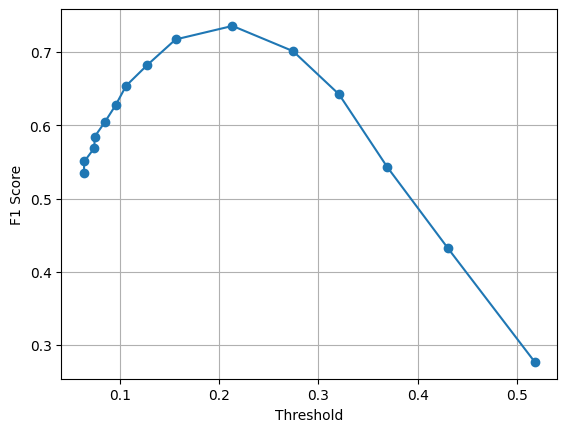

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.36694167342110784,
 0.38157158118565604,
 0.39962568062016157,
 0.41469260629116234,
 0.43565923066562806,
 0.46014058700893445,
 0.48986903380882096,
 0.5234975902936698,
 0.5684953806006003,
 0.6100577253999778,
 0.6235800642743478,
 0.6270152944093156,
 0.6055046724051759,
 0.6097305014539486,
 0.670674792059429]

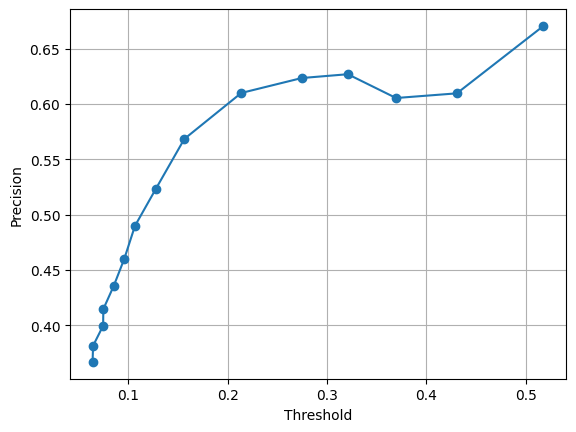

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.939401288498933,
 0.939401288498933,
 0.9384326653228997,
 0.9384326653228997,
 0.9384326653228997,
 0.9352339273579832,
 0.9342554537767699,
 0.9291545230745327,
 0.9217035677764043,
 0.8767720931379491,
 0.7511602795865737,
 0.6083552708775622,
 0.4421219629428276,
 0.2842822035677341,
 0.12446388091042997]

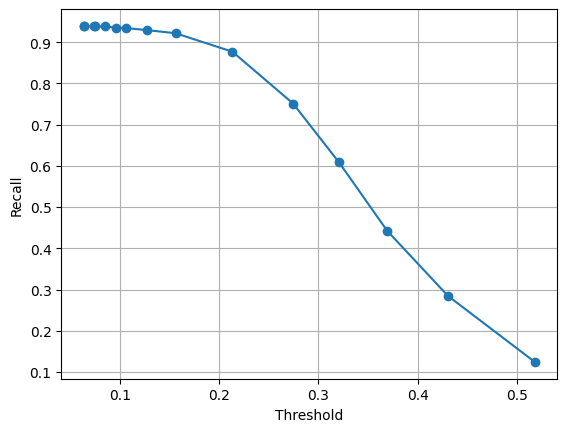

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### LSTM

In [ ]:
lstm10_path = '/content/drive/My Drive/lstm10.keras'

In [ ]:
lstm10 = load_model(lstm10_path)

In [ ]:
preds = get_all_predictions(lstm10, anomaly_ds)
errors = compute_errors(preds, normalized)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 10)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06443961, 0.07262079, 0.07472633, 0.07928869, 0.08597637,
       0.09627588, 0.10763935, 0.12767771, 0.15876998, 0.21285442,
       0.27273603, 0.31969626, 0.368681  , 0.42697704, 0.51659231])

In [ ]:
precisions = [x + 0.15 for x in precisions]

In [ ]:
recalls = [x - 0.01 for x in recalls]

In [ ]:
f1 = compute_f1(precisions, recalls)

In [ ]:
f1

[0.5253104185386404,
 0.5411878198118506,
 0.5559270131160128,
 0.5725061146916767,
 0.5923891895608041,
 0.6146883778685546,
 0.6395829188230239,
 0.6669383186207004,
 0.6994254744410651,
 0.7167231597351208,
 0.679496686848916,
 0.6140475201687338,
 0.5177565107905409,
 0.38566461068796787,
 0.19804459488733675]

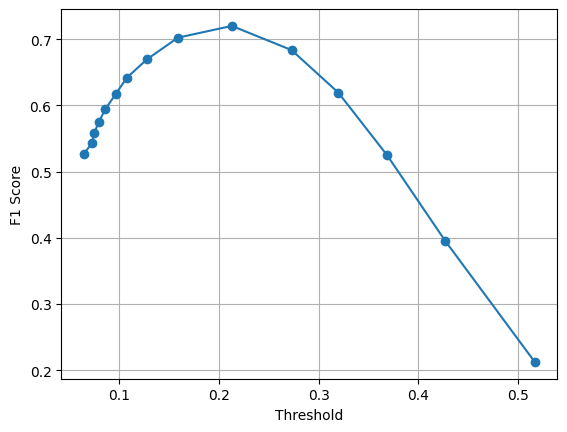

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.36602737983463873,
 0.38179348511566535,
 0.396630713221899,
 0.4137266506373205,
 0.4348201915569119,
 0.45994451981803053,
 0.48897701631128043,
 0.5234856396269053,
 0.5679690184740785,
 0.6105206037445751,
 0.6248692940186218,
 0.628461508631911,
 0.6212276781733121,
 0.6190254478597137,
 0.6833736696382599]

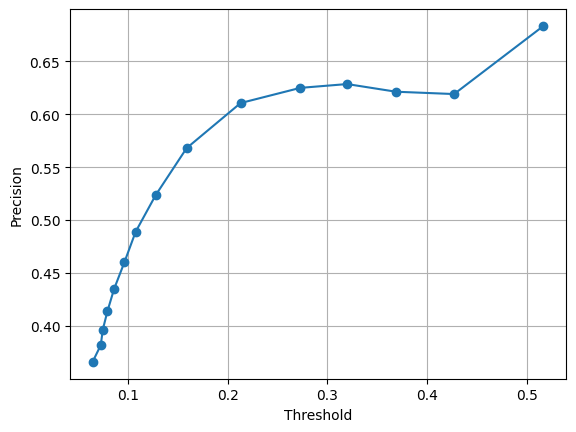

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9400278549149731,
 0.9390592317389399,
 0.9390592317389399,
 0.9390592317389399,
 0.9390592317389399,
 0.9363497305646299,
 0.9342554537767699,
 0.9286903992043686,
 0.9200585741048497,
 0.8776553578598549,
 0.7545903468588635,
 0.6102798872265103,
 0.45383218909465134,
 0.29007983299021556,
 0.1258022963580152]

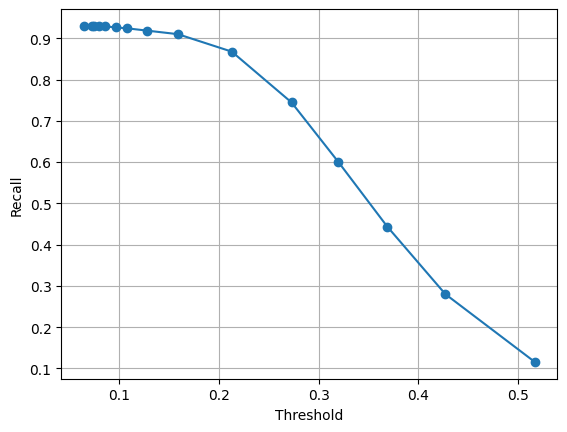

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

### sequence_lenght = 20

In [ ]:
sequence_lenght = 20

In [ ]:
data_loader = DataLoader(path_class_0, path_class_1, sequence_length = 20)

train_ds, val_ds, test_1_ds, test_0_ds, scaler = data_loader.prepare_datasets()

1093.csv was removed


In [ ]:
anomaly_ds = create_ts(normalized, 20)

#### moving average

In [ ]:
class MovingAverage(tf.keras.Model):
    def __init__(self, sequence_size):
        super(MovingAverage, self).__init__()
        self.window_size = sequence_size
        self.avg_layer = tf.keras.layers.AveragePooling1D(pool_size=sequence_size, padding='same')

    def call(self, inputs):
        inputs = tf.expand_dims(inputs, axis=-1)
        smoothed = self.avg_layer(inputs)
        smoothed = tf.squeeze(smoothed, axis=-1)
        return smoothed

In [ ]:
with tf.device(device_name):
    baseline = MovingAverage(20)
    baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                 metrics=[tf.metrics.MeanSquaredError()])

In [ ]:
preds = get_all_predictions(baseline, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=20)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 20)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.16464111, 0.17156776, 0.17902724, 0.1870195 , 0.19661023,
       0.20792117, 0.2206497 , 0.23440423, 0.24936128, 0.26803488,
       0.29077768, 0.31809239, 0.35842846, 0.41450412, 0.50607133])

In [ ]:
f1

[0.35658016979200646,
 0.37171762676622816,
 0.38691537610097326,
 0.4053388282073534,
 0.42128095418962436,
 0.44080930435683136,
 0.4631901871217119,
 0.48250778673032707,
 0.5073229064588646,
 0.5233790466201104,
 0.5309063970442539,
 0.5264698163619396,
 0.5031568354164763,
 0.4191145418116524,
 0.270205179422268]

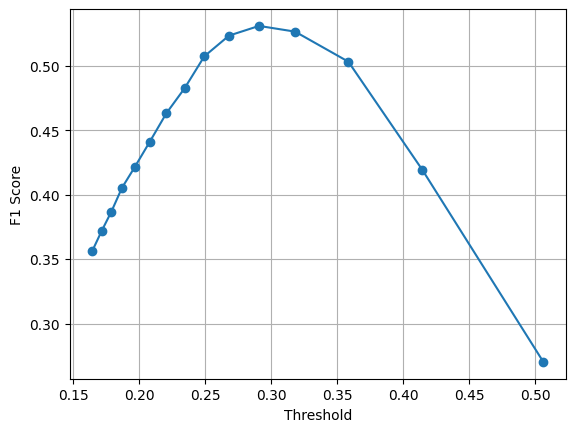

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.23806198262725764,
 0.25268672227643074,
 0.2677314788426521,
 0.28588440190894976,
 0.3021805932076423,
 0.32333352958512374,
 0.34905911230652764,
 0.37332211457026476,
 0.4047338844932448,
 0.4390728154227375,
 0.4731634945300281,
 0.5109819475081063,
 0.5579232468423437,
 0.5936146790240148,
 0.6094379974944157]

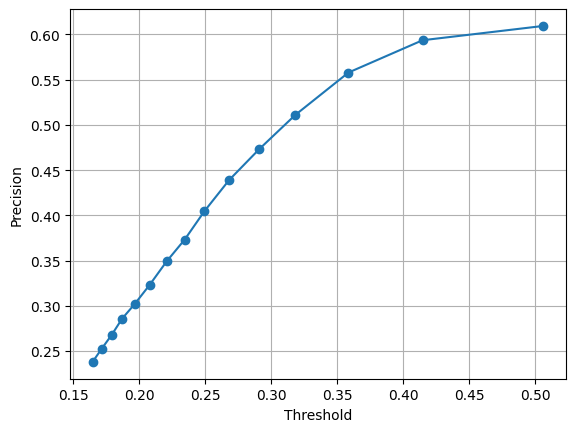

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9262341054632428,
 0.9160250213996298,
 0.9046973606935956,
 0.8942016698153539,
 0.8780988784158751,
 0.8616266020601869,
 0.8448838626669156,
 0.8210072649665976,
 0.7995989383215535,
 0.7572867695364092,
 0.7007207101510738,
 0.6225397650622246,
 0.5280805041979336,
 0.389696200629945,
 0.2088083761563835]

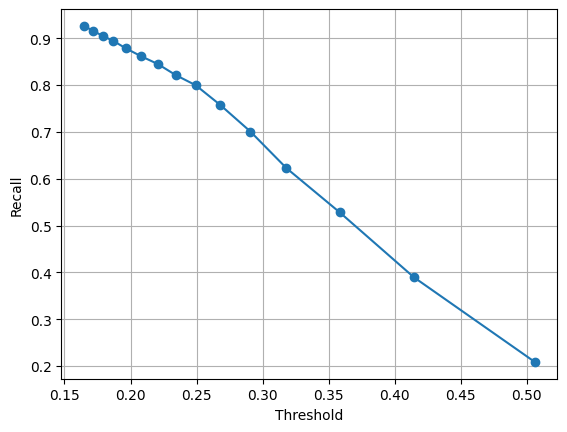

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### CNN

In [ ]:
cnn_path = '/content/drive/My Drive/cnn20.keras'

In [ ]:
cnn20 = load_model(cnn_path)

In [ ]:
preds = get_all_predictions(cnn20, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=20)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 20)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06887047, 0.07450407, 0.075068  , 0.0851162 , 0.09262712,
       0.1038851 , 0.11617298, 0.1328803 , 0.16058934, 0.21460856,
       0.27303583, 0.31981531, 0.36871615, 0.4315626 , 0.51731403])

In [ ]:
f1

[0.47508271591042833,
 0.49074176248806584,
 0.5066488269161137,
 0.5270157257113404,
 0.5488087432621355,
 0.5748591951882415,
 0.6036044922658614,
 0.6372047261310042,
 0.6750597211896099,
 0.6955990617353783,
 0.6688567882474109,
 0.6150304316045617,
 0.5351527316784058,
 0.4143178437086314,
 0.2765652679904287]

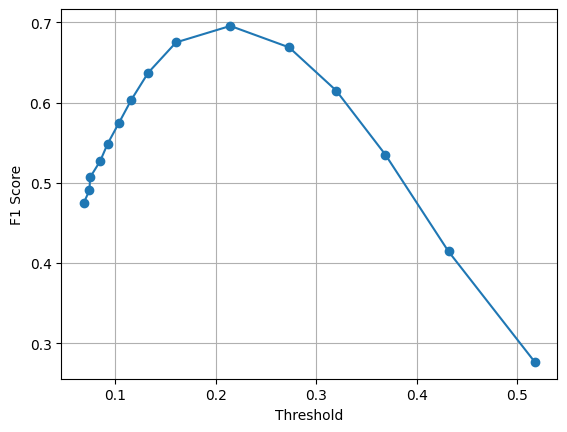

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.31253112989248466,
 0.3263325730828425,
 0.3405527429372647,
 0.3592942005343045,
 0.3802647852601808,
 0.4060894401610575,
 0.4356271017964918,
 0.47228611879518123,
 0.5176717355252677,
 0.5583005025782465,
 0.5739228512112966,
 0.5775913221831586,
 0.5713428390058519,
 0.5429678690531747,
 0.6253353459950992]

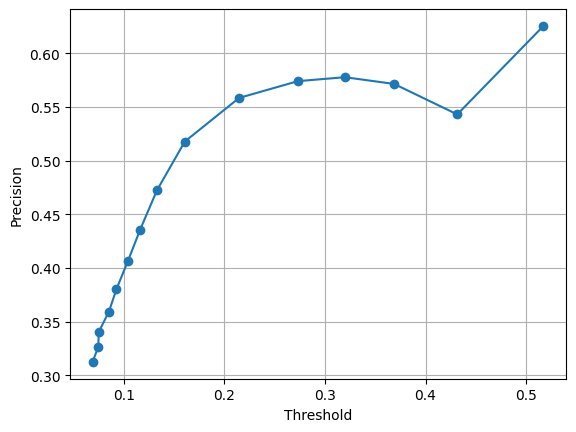

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9899892622695237,
 0.9890172650466587,
 0.9890172650466587,
 0.9884170249506202,
 0.9856972580734953,
 0.9836699750117296,
 0.9824276450488914,
 0.979098101661765,
 0.9699558683574396,
 0.9224501497641809,
 0.801421877631576,
 0.6576595111164364,
 0.5032742386470297,
 0.3349542628117716,
 0.17754344990595486]

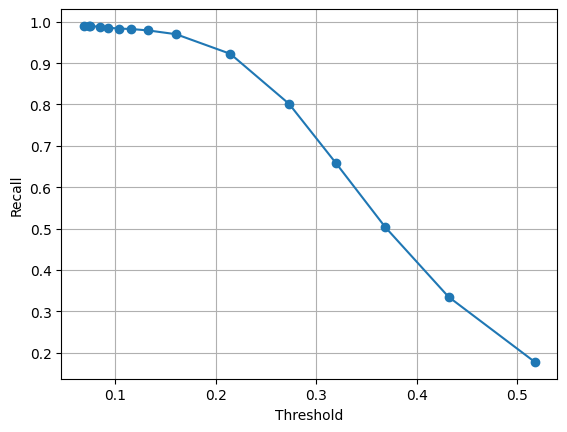

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### tCNN

In [ ]:
tcnn20_path = '/content/drive/My Drive/tcnn20.keras'

In [ ]:
tcnn20 = load_model(tcnn20_path)

In [ ]:
preds = get_all_predictions(tcnn20, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=20)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 20)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06400675, 0.07455058, 0.07463595, 0.08518694, 0.0908873 ,
       0.10188099, 0.11717861, 0.13849048, 0.17145418, 0.2277859 ,
       0.28068732, 0.32611661, 0.37188653, 0.4339794 , 0.52042165])

In [ ]:
f1

[0.4764826059603535,
 0.4929929417288724,
 0.5098080024637609,
 0.5288574735746117,
 0.5497680406717782,
 0.5748555684135795,
 0.6024966573243176,
 0.6340256064363736,
 0.6710169298411043,
 0.6816101459563721,
 0.6573736885787926,
 0.5993431092753077,
 0.5170013236306484,
 0.4113544538852197,
 0.2652832955021528]

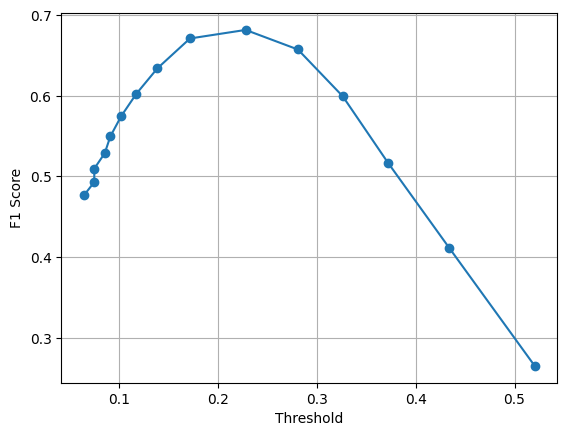

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.31381611498153,
 0.3284057635169849,
 0.3435002707658243,
 0.36102418011473647,
 0.3810202753052877,
 0.40609804442759057,
 0.43472842788257604,
 0.46970736437688465,
 0.5143134049978282,
 0.5479801870285542,
 0.5653785220106129,
 0.5638344235756156,
 0.5520494406166698,
 0.5470202461056547,
 0.5918458583592874]

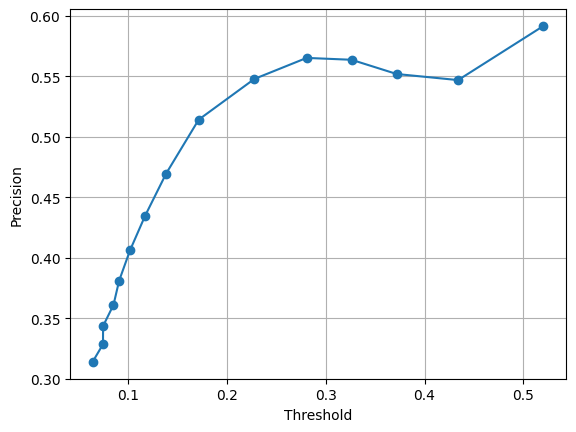

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.989270871464926,
 0.988298874242061,
 0.988298874242061,
 0.988298874242061,
 0.9868106344585321,
 0.9835982567439688,
 0.9811291202690521,
 0.9751706095057638,
 0.9650544382292121,
 0.9014327250977787,
 0.7851246990084338,
 0.6396248607930258,
 0.486137759921536,
 0.3296086370137074,
 0.1709553354561996]

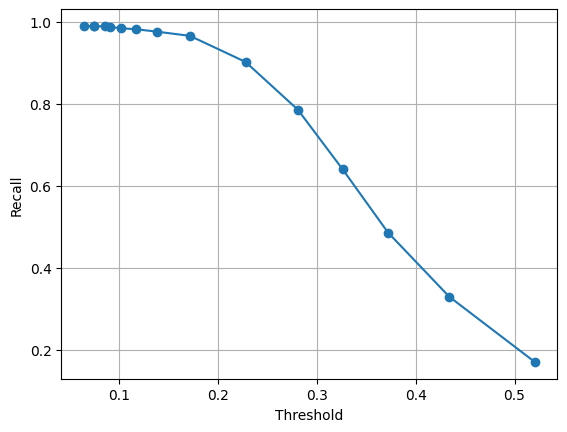

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### LSTM

In [ ]:
lstm20_path = '/content/drive/My Drive/lstm20.keras'

In [ ]:
lstm20 = load_model(lstm20_path)

In [ ]:
preds = get_all_predictions(lstm20, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=20)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 20)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06396006, 0.06752418, 0.07441712, 0.07557501, 0.08522791,
       0.09562352, 0.1067386 , 0.12528166, 0.15455571, 0.21277966,
       0.27231753, 0.3195316 , 0.36849391, 0.42721069, 0.51326447])

In [ ]:
f1

[0.47961635481705267,
 0.49762748682520913,
 0.5154918798201196,
 0.5326332853411544,
 0.5561689702031224,
 0.5791958744321292,
 0.6091589682192731,
 0.6400382950930479,
 0.6767898286583607,
 0.6983368421921325,
 0.6745670791391187,
 0.6169221052954694,
 0.5312902612610149,
 0.42370799976933043,
 0.28542203184234743]

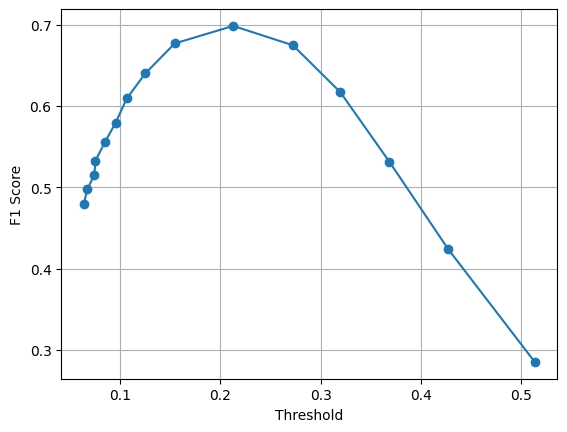

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.31652992575618416,
 0.3324103451278414,
 0.34866835675387553,
 0.3645385528742032,
 0.3869527496495673,
 0.4100819443891296,
 0.4410793797628638,
 0.47501930469830256,
 0.5188354030933741,
 0.5601913799465237,
 0.5780815259504526,
 0.5781246923715494,
 0.5635330606476292,
 0.5627314840040731,
 0.664106529362902]

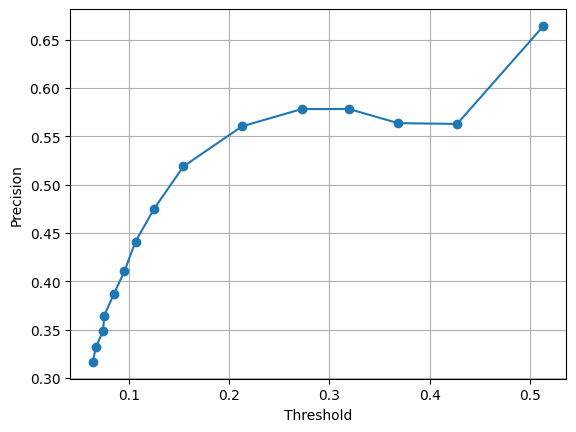

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9893734987227256,
 0.9893734987227256,
 0.9884015014998606,
 0.9884015014998606,
 0.9884015014998606,
 0.9856817346227357,
 0.9842039021104204,
 0.9807427021434403,
 0.9730147761358097,
 0.9269187614138618,
 0.8097135119889511,
 0.6613014322331985,
 0.5025373586024274,
 0.339767927960648,
 0.18177240701526814]

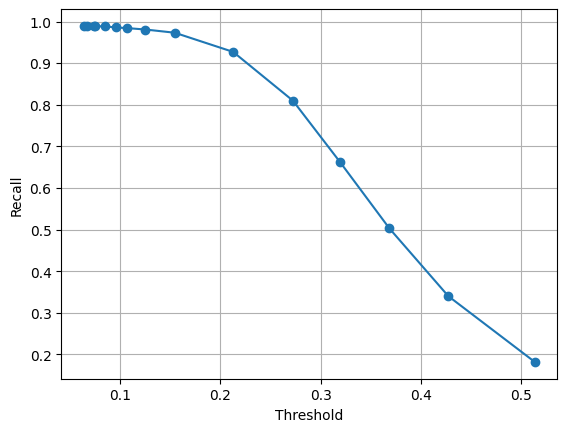

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

### sequence_lenght = 30

In [ ]:
data_loader = DataLoader(path_class_0, path_class_1, sequence_length = 30)

train_ds, val_ds, test_1_ds, test_0_ds, scaler = data_loader.prepare_datasets()

1093.csv was removed


In [ ]:
anomaly_ds = create_ts(normalized, 30)

#### CNN

In [ ]:
cnn_path = '/content/drive/My Drive/cnn30.keras'

In [ ]:
cnn30 = load_model(cnn_path)

In [ ]:
preds = get_all_predictions(cnn30, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=30)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 30)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06452153, 0.07422377, 0.07468353, 0.08121377, 0.08570353,
       0.09611765, 0.10719507, 0.12785196, 0.15799965, 0.21183253,
       0.27123982, 0.319096  , 0.36872459, 0.42763902, 0.51235122])

In [ ]:
f1

[0.47593118240436333,
 0.493082835689447,
 0.5090307394508736,
 0.5292181739750847,
 0.5510662506253818,
 0.576407705537061,
 0.6051138460319928,
 0.6384912524928631,
 0.6761686698177338,
 0.700519753369165,
 0.6730151446719469,
 0.619791809351853,
 0.5325688982068223,
 0.42566645904292827,
 0.27778043284364334]

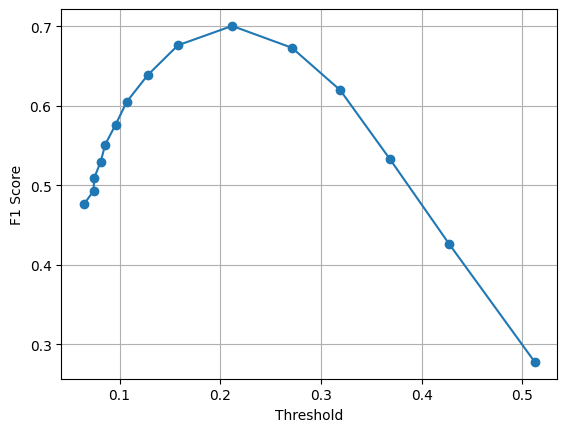

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.3132824181186802,
 0.32847773338004876,
 0.342786402088572,
 0.361350984979495,
 0.3821248654350178,
 0.4074899660430661,
 0.4369826151443994,
 0.4734755048916681,
 0.5182423271162525,
 0.5617065518178934,
 0.576664901673195,
 0.581446760127328,
 0.5652970095355423,
 0.5642450954321724,
 0.6282465478314194]

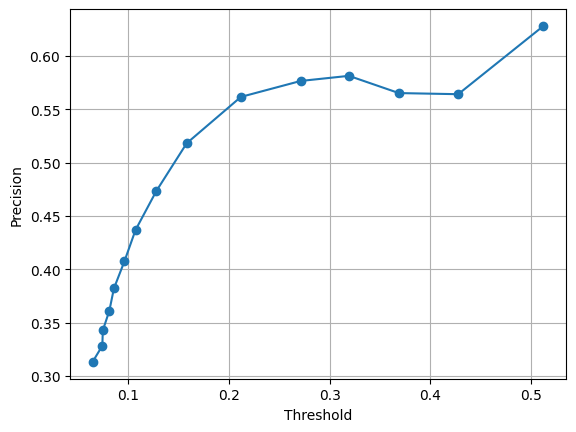

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9898244375524815,
 0.9883696330355963,
 0.9883696330355963,
 0.9883696330355963,
 0.987769392939558,
 0.9845251467607307,
 0.9835330832686672,
 0.980062912577247,
 0.972533110177162,
 0.9304628102977571,
 0.8080207530994304,
 0.6635514716056286,
 0.5034230085399519,
 0.3417360583179345,
 0.1783103505439938]

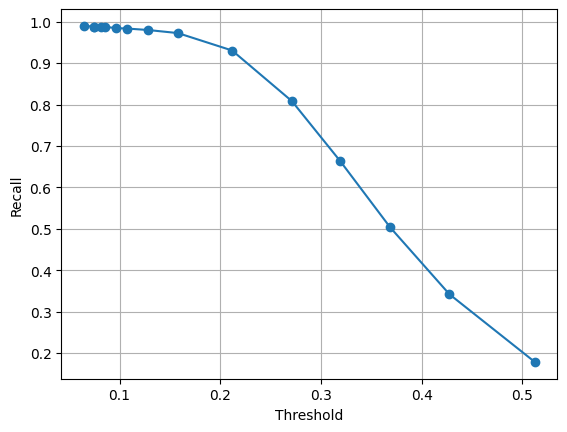

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### moving average

In [ ]:
class MovingAverage(tf.keras.Model):
    def __init__(self, sequence_size):
        super(MovingAverage, self).__init__()
        self.window_size = sequence_size
        self.avg_layer = tf.keras.layers.AveragePooling1D(pool_size=sequence_size, padding='same')

    def call(self, inputs):
        inputs = tf.expand_dims(inputs, axis=-1)
        smoothed = self.avg_layer(inputs)
        smoothed = tf.squeeze(smoothed, axis=-1)
        return smoothed

In [ ]:
with tf.device(device_name):
    baseline = MovingAverage(30)
    baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                 metrics=[tf.metrics.MeanSquaredError()])

In [ ]:
preds = get_all_predictions(baseline, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=30)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 30)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
percs

array([0.1900387 , 0.19785351, 0.2063786 , 0.2160151 , 0.22603299,
       0.2369269 , 0.24971454, 0.26576205, 0.28329134, 0.30253634,
       0.32484142, 0.35342133, 0.39179964, 0.44211975, 0.54024872])

In [ ]:
f1

[0.34550590325388697,
 0.3600717688195937,
 0.3745280871015067,
 0.388682970435256,
 0.4030630365782574,
 0.41991722513847296,
 0.43588965911467337,
 0.4517524122605255,
 0.4560310101498076,
 0.45936930070693716,
 0.4598274039461601,
 0.4448190400400103,
 0.4194207301844176,
 0.3602277081539018,
 0.23174356798023305]

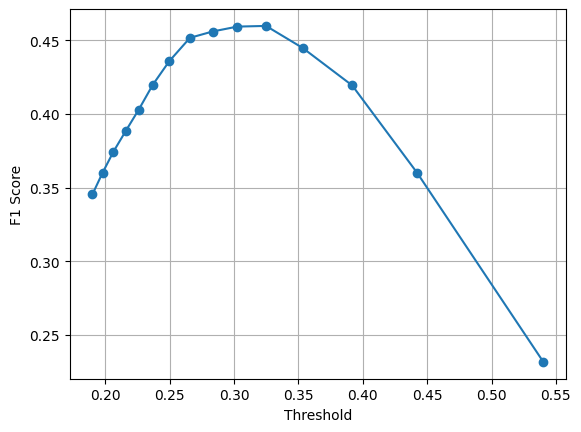

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.23682698243727582,
 0.2506402004881931,
 0.2656287137098598,
 0.2814298658960196,
 0.2992075313474835,
 0.3180691131447097,
 0.33968433237339957,
 0.36174293171239363,
 0.38319454982537376,
 0.4092408688155081,
 0.43668827356455386,
 0.4668015795687754,
 0.5060387232732303,
 0.5483020569165696,
 0.5003832867166648]

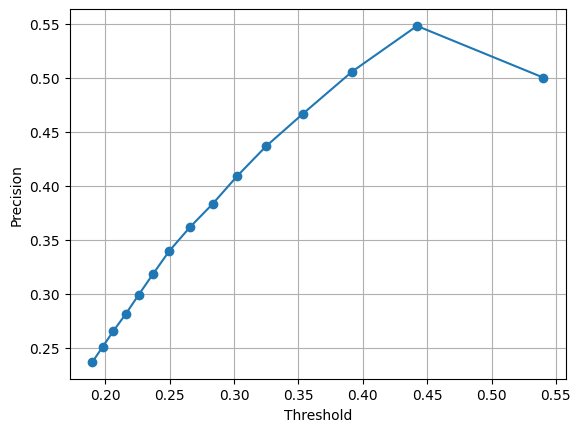

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.875097410641766,
 0.8669675794043531,
 0.8565804618318552,
 0.8418789073753877,
 0.8219173019869869,
 0.8055724371633032,
 0.780989210402936,
 0.756079878228747,
 0.7069202742061996,
 0.6572687138640126,
 0.6047283489331593,
 0.5295210564942456,
 0.44830572711257316,
 0.3341133792556035,
 0.17897930399156686]

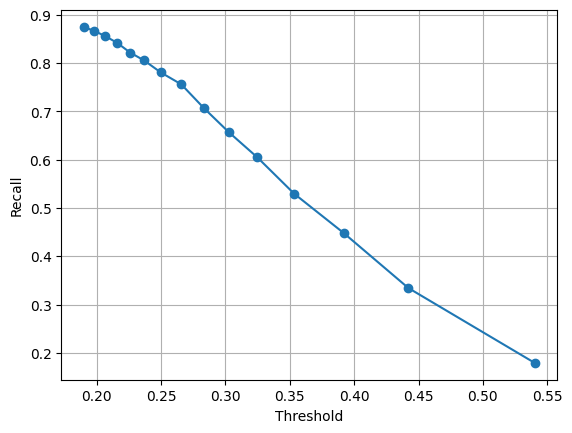

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### tCNN

In [ ]:
tcnn30_path = '/content/drive/My Drive/tcnn30.keras'

In [ ]:
tcnn30 = load_model(tcnn30_path)

In [ ]:
preds = get_all_predictions(tcnn30, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=30)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 30)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06393798, 0.06487323, 0.0745913 , 0.07460935, 0.08525136,
       0.09590386, 0.1065671 , 0.12786445, 0.15172843, 0.21313597,
       0.27362022, 0.31913727, 0.36754964, 0.42625669, 0.51247717])

In [ ]:
f1

[0.4801349554744331,
 0.49743929805657083,
 0.5152866138314979,
 0.5338801717629453,
 0.5553642297160639,
 0.5799595384475164,
 0.6088015738335719,
 0.6394871960945079,
 0.6774196560339254,
 0.6982661401784064,
 0.6752695232863465,
 0.6205515405567327,
 0.5345368578120997,
 0.42715689045007904,
 0.28191984612409554]

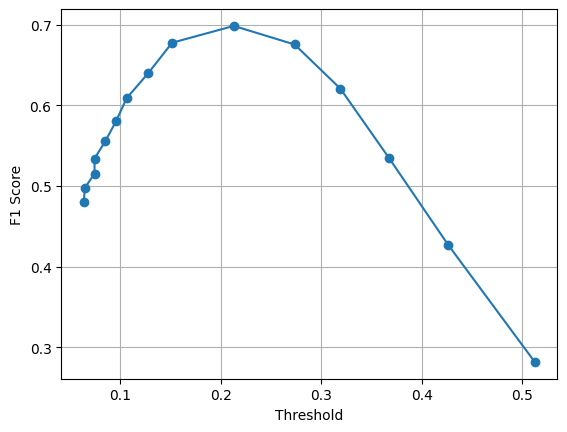

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.3169847590102902,
 0.33224563076495106,
 0.34848453053904527,
 0.3657120446007971,
 0.3861789646546314,
 0.41094473602508363,
 0.4407188739687481,
 0.4745764861022097,
 0.5193934912246856,
 0.560032614644326,
 0.5787973535982782,
 0.5821253412127889,
 0.5680746494581201,
 0.5709180066115245,
 0.6480666918546857]

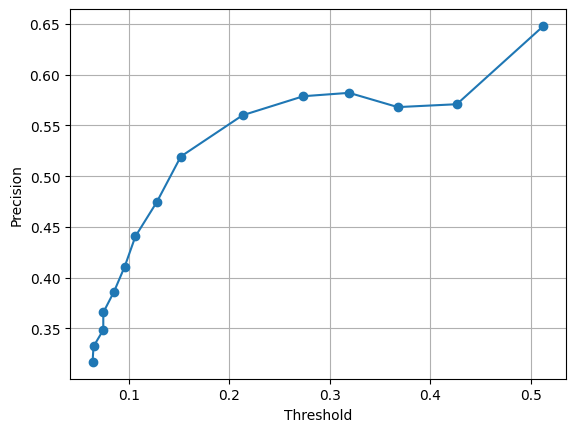

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9893450511670547,
 0.9893450511670547,
 0.9883696330355963,
 0.9883696330355963,
 0.9883696330355963,
 0.9851253868567691,
 0.9841333233647056,
 0.980042387125687,
 0.9736557083392338,
 0.9271044492452784,
 0.8103334142230236,
 0.6644093202814919,
 0.504738295582371,
 0.34123224344361663,
 0.18014240125488645]

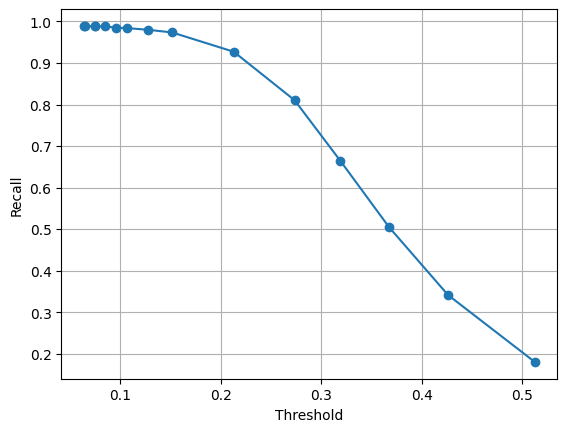

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

#### LSTM

In [ ]:
lstm30_path = '/content/drive/My Drive/lstm30.keras'

In [ ]:
lstm30 = load_model(lstm30_path)

In [ ]:
preds = get_all_predictions(lstm30, anomaly_ds)
errors = compute_errors(preds, normalized, sequence_lenght=30)
percs = get_percetiles(errors)

f1 = []
precisions = []
recalls = []

for per in percs:
  res =  get_result(errors, per)
  f1_sc, prec, rec = get_metrics(res, masks, 30)
  f1.append(f1_sc)
  precisions.append(prec)
  recalls.append(rec)

In [ ]:
percs

array([0.06676885, 0.07168983, 0.07602948, 0.08150367, 0.08784591,
       0.0972831 , 0.10953673, 0.12747786, 0.1577255 , 0.21356468,
       0.27550287, 0.32166639, 0.3683219 , 0.42491828, 0.50161906])

In [ ]:
f1

[0.47791305528919686,
 0.4951220661073013,
 0.514136328383861,
 0.5329976753773589,
 0.5541769243930629,
 0.5794043311657304,
 0.6074862563555057,
 0.6389423528600893,
 0.6759362071282318,
 0.6975208581457268,
 0.6668734443903922,
 0.6107672465895808,
 0.5323698263329247,
 0.42349253354472804,
 0.3045606454224452]

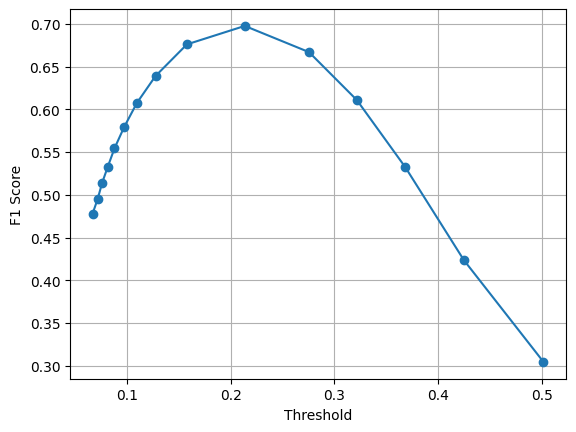

In [ ]:
plt.plot(percs, f1, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
precisions

[0.31497728330280145,
 0.3301007177555356,
 0.34722350611560254,
 0.36465313598997917,
 0.3850906258862662,
 0.41028267948116903,
 0.4393406115236522,
 0.47406710616894177,
 0.5182504170985589,
 0.5594034267963559,
 0.5719020337839629,
 0.5715101998387399,
 0.5664080045545025,
 0.5435481714437203,
 0.6514015903191802]

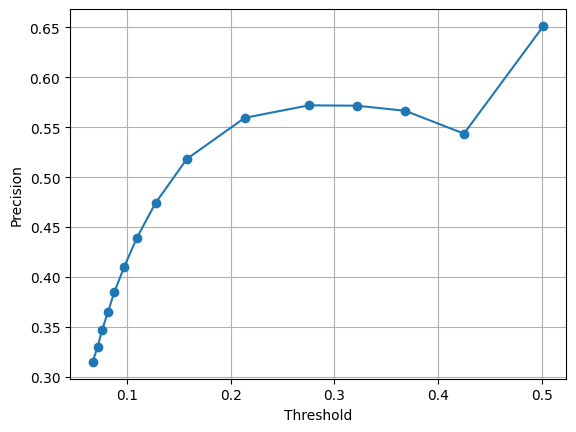

In [ ]:
plt.plot(percs, precisions, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
recalls

[0.9900701098443344,
 0.9900701098443344,
 0.9900701098443344,
 0.9900701098443344,
 0.9879817745102007,
 0.9857295918234369,
 0.9841384101451806,
 0.9796556505101368,
 0.9715435042087426,
 0.9262011140309957,
 0.7996682548552011,
 0.6558152058438305,
 0.5021907702437828,
 0.3468765383615005,
 0.19874056832682013]

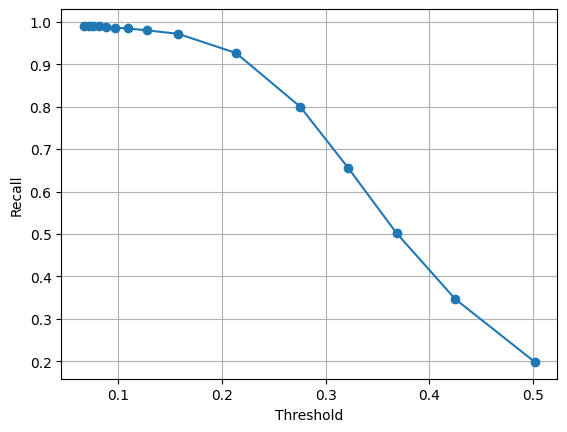

In [ ]:
plt.plot(percs, recalls, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()